# COMP 527: Implementing the k-means clustering algorithm

> In the assignment, you are required to cluster words belonging to four categories: animals, countries, fruits and veggies. The words are arranged into four different files. The first entry in each line is a word followed by 300 features (word embedding) describing the meaning of that word.

## Implementation
 
> (1) Implement the k-means clustering algorithm with Euclidean distance to cluster the instances into k clusters. (30 marks)

In [22]:
import numpy as np   # for handling vectors
import matplotlib.pyplot as plt    # for plotting results
import pandas as pd    # for neatly displaying results in table

In [23]:
class Word():
    """Object class for a categorized word with data vector."""
    
    def __init__(self, name, vector, category):
        """Initialize Word object."""
        self.name = name
        self.vector = vector
        self.category = category
    
    def __repr__(self):
        """Define printable representation."""
        desc = f"{self.name} ({self.category}):" + \
            f"[{self.vector[0]},...,{self.vector[len(self.vector) - 1]}] ({len(self.vector)}-dim.)"
        return desc
    
    def dot(self, other):
        """Allow dot products of word vectors directly."""
        
        return self.vector.dot(other.vector)

In [24]:
class Dataset():
    
    def __init__(self, list_of_filenames):
        """Read in Word data from various files."""
        
        self.data = []
        self.categories = list_of_filenames
        self.dim = None
        
        for category in list_of_filenames:
            lines = open(category).read().split('\n')[:-1]

            for word_data in lines:
                split = word_data.split(' ')
                name = split[0]
                for other_word in self.data:
                    if other_word.name == name:
                        print(f"'{name}' is already named, but we add it again anyway.\nYou can remove with `.remove('{name}')`")
                
                raw_list = split[1:]

                floats = []
                    
                for x_string in raw_list:
                    floats.append(float(x_string))

                if not self.dim:
                    # define dimensionality of dataset
                    # based on length of first vector
                    self.dim = len(floats)
                else:
                    # require that all vectors are same length
                    assert self.dim == len(floats),\
                        'Data vectors are not all of same length!'

                vector = np.array(floats)

                self.data.append( Word(name, vector, category))
                
    def __repr__(self):
        """Define printable representation of Dataset."""
        
        summary = f'Collection of {len(self.data)} words'\
                    + f' from {len(self.categories)} categories,'\
                    + f' with {self.dim}-dimensional feature vectors.'
        
        return summary
    
    def select(self, word_name):
        """Select Word from Dataset by name."""
        
        selected = []
        for w in self.data:
            if w.name == word_name:
                selected.append(w)
        
        if len(selected) == 1:
            return selected[0]
        else:
            return selected
    
    def repeats(self):
        """Check for repetitions and return list of tuples."""
        
        repetitions = []
        for i, word1 in enumerate(self.data):
            for word2 in self.data[i:]:
                if word1 != word2:
                    if word1.name == word2.name:
                        repetitions.append((word1, word2))
                        
        return repetitions
                    
    def remove(self, name, word=None):
        """Remove Word, specified by name, or by identical object."""
        
        if word:
            for w in self.data:
                if word == w:
                    self.data.remove(w)
                    print(f'Removed {w}.')
                    return
                
        else:
            for w in self.data:
                if name == w.name:
                    self.data.remove(w)
                    print(f'Removed {w}.')
                    return
        
        print('Nothing was removed.')
        return

In [25]:
words = Dataset(['fruits','veggies','animals','countries'])

'cucumber' is already named, but we add it again anyway.
You can remove with `.remove('cucumber')`


In [26]:
words.repeats()

[(cucumber (fruits):[-0.88559,...,0.22113] (300-dim.),
  cucumber (veggies):[-0.88559,...,0.22113] (300-dim.))]

In [27]:
def euclidean_distance(u,v):
    """Return Euclidean distance between two np.array vectors."""
    
    return np.sqrt( (u - v).dot( u - v ))

In [28]:
def manhattan_distance(u,v):
    """Return Manhattan distance between two np.array vectors."""
    
    w = u - v
    distance = 0
    for x in w:
        distance += abs(x)
    
    return distance

In [29]:
def cosine_similarity(u, v):
    """Return cosine similarity of two np.array vectors."""
    
    if np.array_equal(u, v):
        # we specify this to avoid rounding errors
        cos_theta = 1
    else:
        cos_theta = u.dot(v)/( np.sqrt(u.dot(u)) * np.sqrt(v.dot(v)) )
    
    return cos_theta

In [30]:
def angular_distance(u, v):
    """Return angular distance between two np.array vectors."""

    cos_theta = cosine_similarity(u, v)

    theta = np.arccos(cos_theta)
    
    if theta < 0:
        theta += 2 * np.pi
    
    return theta

In [31]:
def normalize(data):
    """Return normalized vectors (ie. parallel vector with unit magnitude)."""
    
    normalized_data = []
    
    for d in data:
        normalized_vector = d.vector / np.sqrt( d.vector.dot(d.vector) )
        normalized_data.append(Word(d.name, normalized_vector, d.category))
        
    return normalized_data

In [32]:
class KMeans():
    
    def __init__(
                self, 
                k, 
                D, 
                metric = euclidean_distance, 
                normed = False, 
                max_iterations = 10**3, 
                seed = None,
                ):
        """
        Initialize KMeans Model.
        
        Args:
            k (int): number of clusters to divide data into.
            D (Dataset): as defined by Dataset() class.
            metric (function): to measure distance between points.
            norm (Boolean): whether or not to normalize vectors.
            iterations (int): when to stop if no convergence.
            seed (int): for reproducible (pseudo-)randomness.
        """
        
        self.k = k
        self.D = D
        self.normed = normed
        if self.normed == True:
            self.data = normalize(D.data)
        else:
            self.data = D.data
        
        self.metric = metric
                
        if seed:
            self.seed = seed
        else:
            self.seed = np.random.randint(0, 2**32)
        np.random.seed(seed)
        
        # we track centroid positions and cluster labels in nested dicts,
        # of the form dict_name[iteration_number][centroid_number]
        self._centroid = {}
        
        self._cluster = {}

        # we record cluster labels explicitly as well
        self._label = {}
        
        self.max_iterations = max_iterations
        for i in range(self.max_iterations):
            self._iteration = i
            self._iterate()
            if i > 0 and self._cluster[i] == self._cluster[i-1]:
                break
        
        self.cluster = self._cluster[self._iteration]
        self.label = self._label[self._iteration]
        
        self.convergence = self._iteration + 1
        if self.convergence == max_iterations:
            self.convergence = np.nan
        
        self._evaluate()
        
    def __repr__(self):
        """Representation of model."""
        
        desc = f"k = {self.k}"
    
    
    def _start(self):
        """Shuffle dataset and position centroids on first k datapoints."""
        
        selected = np.random.permutation(self.data)[0:self.k]
        
        self._centroid[0] = {}
        
        for centroid_number in range(self.k):
            self._centroid[0][centroid_number] = selected[centroid_number].vector
           
    
    def _classify(self):
        """Assign each data point to cluster of nearest centroid."""
        
        self._cluster[self._iteration] = {}
        self._label[self._iteration] = {}
        
        for centroid_number in range(self.k):
            self._cluster[self._iteration][centroid_number] = []
        
        for d in self.data:
            distances = [] 
            
            for centroid_number in range(self.k):
                
                distances.append(self.metric(d.vector, self._centroid[self._iteration][centroid_number]))
            
            closest_centroid = np.argmin(distances)
            
            self._cluster[self._iteration][closest_centroid].append(d)
            self._label[self._iteration][d.name] = closest_centroid
        
            
    def _reposition(self):
        """Move centroids to mean of each cluster."""
        
        for centroid_number in range(self.k):
            self._centroid[self._iteration] = {}
        
        for centroid_number in range(self.k):
            
            clustered = self._cluster[self._iteration - 1][centroid_number]
            
            if len(clustered) > 0:
                vector_sum = np.zeros(len(clustered[0].vector))
                
                for datum in clustered:
                    vector_sum += datum.vector

                cluster_mean = vector_sum / len(clustered)

                self._centroid[self._iteration][centroid_number] = cluster_mean

            else:
                # nothing assigned to this cluster so position is unchanged
                self._centroid[self._iteration][centroid_number] = \
                        self._centroid[self._iteration - 1][centroid_number]
           
   
    def _iterate(self):
        """Position centroids and classify data by nearest centroid."""
        
        if self._iteration == 0:
            self._start()
        else:
            self._reposition()
        
        if self._iteration == self.max_iterations:
            self._stop()
        else:
            self._classify()
            
            
    def _evaluate(self):
        """Evaluate success of clustering."""
        
        self.true_positives = 0
        self.true_negatives = 0
        self.false_positives = 0
        self.false_negatives = 0
        
        data = self.data
        
        for i in range(len(data)):
            for j in range(i+1, len(data)):
                if data[i].category == data[j].category \
                and self.label[data[i].name] == self.label[data[j].name]:
                    self.true_positives += 1
                if data[i].category != data[j].category \
                and self.label[data[i].name] == self.label[data[j].name]:
                    self.false_positives += 1
                if data[i].category != data[j].category \
                and self.label[data[i].name] != self.label[data[j].name]:
                    self.true_negatives += 1
                if data[i].category == data[j].category \
                and self.label[data[i].name] != self.label[data[j].name]:
                    self.false_negatives += 1
                    
        
        self.precision = self.true_positives / (self.true_positives + self.false_positives)
        self.recall = self.true_positives / (self.true_positives + self.false_negatives)
        self.f_score = 2 * self.precision * self.recall / (self.precision + self.recall)
        
        self.score = f'Precision: {self.precision}.\nRecall: {self.recall}.\nF-Score: {self.f_score}.\n'
        
    def describe(self):
        """Describe model clusters."""
        
        desc = ""
        for i in range(self.k):
            desc += f"Cluster {i} includes {len(self.cluster[i])} elements.\n"
            
            count = {}
            for category in self.D.categories:
                count[category] = 0
                for word in self.cluster[i]:
                    if word.category == category:
                        count[category] += 1
                if count[category] > 0:
                       desc += f"{count[category]} are {category}.\n"
            desc += '\n'
            
        print(f'K-Means Model\n\nParameters:\nk={self.k}\nD={self.D}\nmetric={self.metric}\nnormed={self.normed}\nseed={self.seed}\n')
        print(f'Converged after {self.convergence} iterations.\n')
        print(self.score)
        print(desc)

## Compute Precision, Recall, and F-Score

> (2) Vary the value of k from 1 to 10 and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

In [33]:
words = Dataset(['animals','countries','fruits','veggies'])

'cucumber' is already named, but we add it again anyway.
You can remove with `.remove('cucumber')`


In [34]:
measures = 'precision', 'recall', 'f_score'

In [35]:
def get_scores(metric, normed=False, max_k=10, seed=1):
    scores = {}
    for measure in measures:
        scores[measure] = []
    model = {}
    for k in range(1, max_k+1):
        model[k] = KMeans(k=k, D=words, metric=metric, normed=normed, seed=seed)
        for measure in measures:
            scores[measure].append( getattr(model[k], measure) )
            
    return scores

In [36]:
def show_results(scores):
    """For convenience' sake."""

    max_k = len(scores[measures[0]])
    
    fig, ax = plt.subplots(figsize=(15,8))

    for measure in measures:
        ax.plot(range(1,max_k + 1), scores[measure], label = measure)

    ax.set_xticks(range(1,max_k + 1))
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Evaluation Score')
    ax.set_yticks(np.arange(0,max_k + 1)/max_k)
    ax.set_xlim(1,max_k)
    ax.set_ylim(0,1.01)
    ax.legend()

    plt.show()

    scores['k'] = list(range(1,10+1))
    table = pd.DataFrame(scores).set_index('k')
    return table.transpose()
    

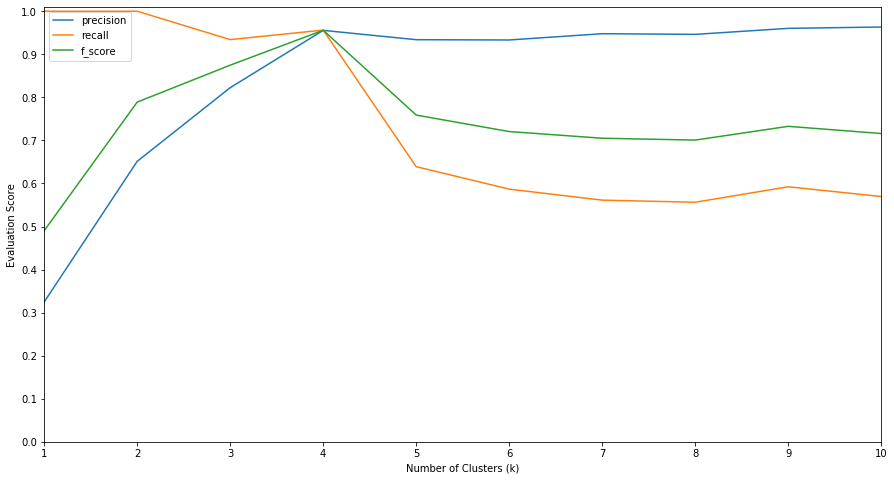

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.822433,0.955528,0.933884,0.933218,0.947784,0.946245,0.960229,0.963338
recall,1.000000,1.000000,0.934105,0.956127,0.639035,0.586775,0.561273,0.556367,0.592309,0.569660
f_score,0.490403,0.788910,0.874720,0.955827,0.758824,0.720516,0.705031,0.700726,0.732675,0.715950


In [37]:
show_results(get_scores(euclidean_distance, seed=99989))

## Normalize

> (3) Now re-run the k-means clustering algorithm you implemented in part (1) but normalise each feature vector to unit $ L_2 $ length before computing Euclidean distances. Vary the value of k from 1 to 10 and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

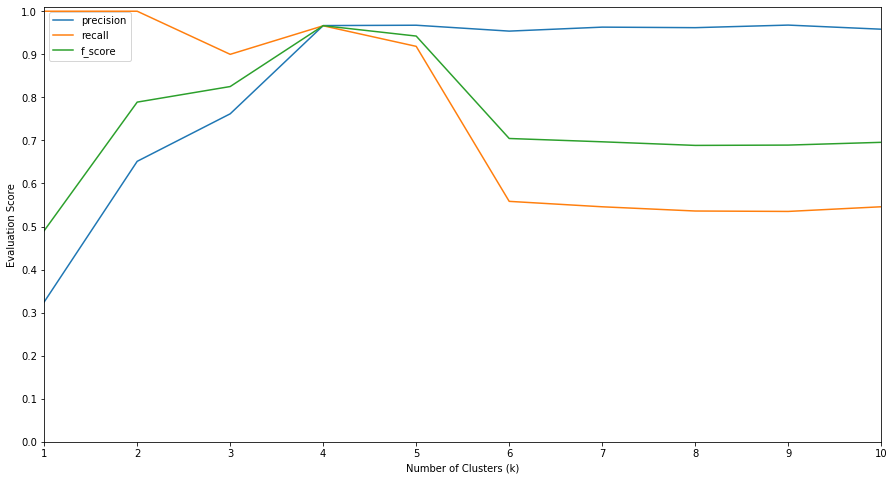

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.761760,0.966665,0.967486,0.953810,0.963056,0.961814,0.967802,0.958237
recall,1.000000,1.000000,0.899874,0.966168,0.918416,0.558421,0.545812,0.536000,0.535030,0.545869
f_score,0.490403,0.788910,0.825077,0.966417,0.942313,0.704426,0.696745,0.688379,0.689103,0.695526


In [38]:
show_results(get_scores(euclidean_distance, normed=True, seed=99989))

## Manhattan Distance

> (4) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use Manhattan distance over the unnormalised feature vectors. Vary the value of k from 1 to 10
and compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

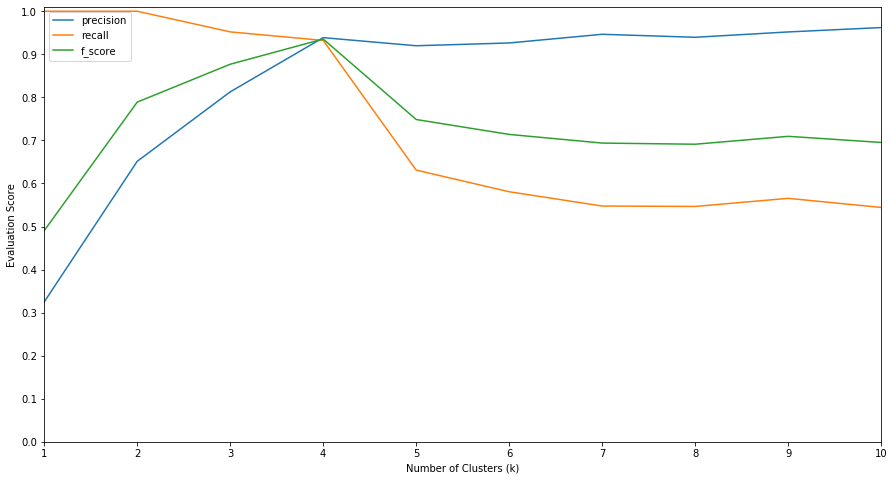

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.812731,0.938649,0.919827,0.926290,0.946455,0.939498,0.951882,0.962081
recall,1.000000,1.000000,0.952020,0.932223,0.630990,0.580728,0.547581,0.546611,0.565438,0.544272
f_score,0.490403,0.788910,0.876879,0.935425,0.748511,0.713890,0.693773,0.691120,0.709449,0.695234


In [39]:
show_results(get_scores(manhattan_distance, normed=False, seed=99989))

## Normalized Manhattan Distance

> (5) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use Manhattan distance with $ L_2 $ normalised feature vectors. Vary the value of k from 1 to 10 and
compute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

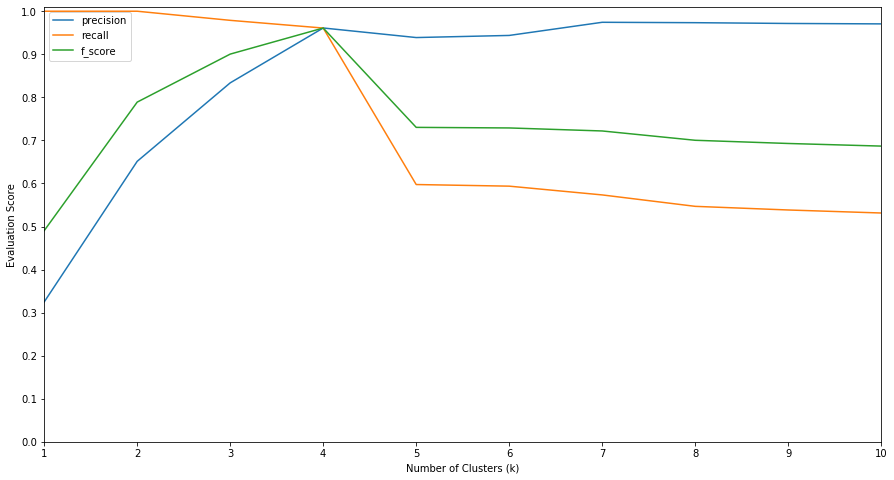

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.833633,0.961084,0.938861,0.943774,0.974309,0.973393,0.971584,0.970613
recall,1.000000,1.000000,0.978834,0.960920,0.597501,0.593736,0.573368,0.546839,0.538396,0.531378
f_score,0.490403,0.788910,0.900417,0.961002,0.730258,0.728909,0.721905,0.700274,0.692853,0.686772


In [40]:
show_results(get_scores(manhattan_distance, normed=True, seed=99989))

##  Cosine Similarity

> (6) Now re-run the k-means clustering algorithm you implemented in part (1) but this time use cosine similarity as the distance (similarity) measure.Vary the value of k from 1 to 10 andcompute the precision, recall, and F-score for each set of clusters. Plot k in the horizontal axis and precision, recall and F-score in the vertical axis in the same plot. (10 marks)

Using cosine similarity directly with our k-means clustering algorithm will not work properly, as it is not a true metric.

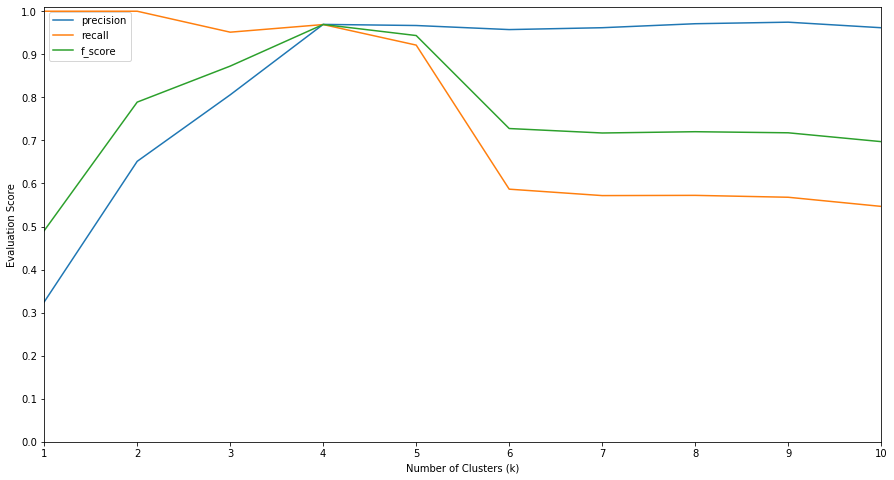

k,1,2,3,4,5,6,7,8,9,10
precision,0.324857,0.651405,0.805828,0.969408,0.966832,0.957364,0.961716,0.970964,0.974547,0.961666
recall,1.000000,1.000000,0.951335,0.969021,0.921326,0.586718,0.571828,0.572341,0.567948,0.546725
f_score,0.490403,0.788910,0.872557,0.969215,0.943531,0.727556,0.717209,0.720172,0.717659,0.697123


In [48]:
show_results(get_scores(angular_distance, seed=99989))

## Compare and Discuss

> (7) Comparing the different clusterings you obtained in (2)-(6) discuss what is the best setting for k-means clustering for this dataset. (20 marks)

In [41]:
def select_best_setting(seed):
    
    metrics = euclidean_distance, manhattan_distance, angular_distance
    
    normed = False, True
    
    results = {}
    
    for m in metrics:
        for boolean in normed:
            results[f'{m.__name__}, normed={boolean}'] = \
                        KMeans(k=4, D=words, metric=m, normed=boolean, max_iterations=100, seed=seed).f_score
    
    print(max(results, key=lambda key: results[key]))
    
    return results

In [42]:
seeded_results = {}
for i in range(15):
    seeded_results[i] = select_best_setting(i)

euclidean_distance, normed=False
angular_distance, normed=False
angular_distance, normed=False
angular_distance, normed=False
angular_distance, normed=False
euclidean_distance, normed=False
manhattan_distance, normed=True
angular_distance, normed=True
angular_distance, normed=True
euclidean_distance, normed=False
manhattan_distance, normed=False
euclidean_distance, normed=True
euclidean_distance, normed=False
angular_distance, normed=True
angular_distance, normed=False


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
"euclidean_distance, normed=False",0.689468,0.932914,0.942758,0.663455,0.951888,0.719766,0.937709,0.942758,0.582002,0.697747,0.696591,0.504114,0.775315,0.951727,0.752118
"euclidean_distance, normed=True",0.689468,0.958201,0.961002,0.691673,0.960005,0.713318,0.649431,0.958201,0.667937,0.694601,0.687666,0.724263,0.689468,0.963565,0.961002
"manhattan_distance, normed=False",0.508260,0.944333,0.958384,0.676255,0.958406,0.709995,0.938577,0.958201,0.594844,0.679511,0.763871,0.502615,0.670690,0.961017,0.775827
"manhattan_distance, normed=True",0.682495,0.960756,0.969213,0.683274,0.961017,0.694792,0.972068,0.960849,0.673047,0.683146,0.679056,0.706068,0.690260,0.961017,0.969213
"angular_distance, normed=False",0.684889,0.966422,0.974981,0.692569,0.969215,0.713318,0.651866,0.966422,0.683155,0.688588,0.683238,0.709443,0.724263,0.966422,0.969215
"angular_distance, normed=True",0.689468,0.966417,0.974903,0.691673,0.969215,0.713318,0.653790,0.969192,0.687420,0.693545,0.687420,0.711344,0.689468,0.966428,0.969213


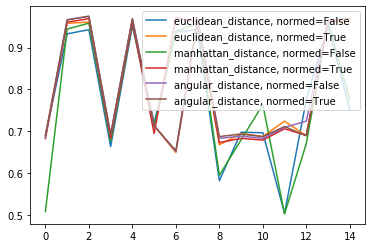

In [43]:
table = pd.DataFrame(seeded_results)
table.transpose().plot()
table

In [45]:
table.transpose().describe()

,"euclidean_distance, normed=False","euclidean_distance, normed=True","manhattan_distance, normed=False","manhattan_distance, normed=True","angular_distance, normed=False","angular_distance, normed=True"
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.782689,0.797987,0.773386,0.816418,0.802934,0.802188
std,0.150097,0.138216,0.169605,0.143965,0.141100,0.141776
min,0.504114,0.649431,0.502615,0.673047,0.651866,0.653790
25%,0.693030,0.689468,0.673473,0.683210,0.686738,0.689468
50%,0.752118,0.713318,0.763871,0.706068,0.713318,0.711344
75%,0.940234,0.959103,0.951267,0.961017,0.966422,0.967810
max,0.951888,0.963565,0.961017,0.972068,0.974981,0.974903


In [75]:
b

[1, 2, 3]

Based on the results we obtained in (2)-(6), the best setting for K-Means clustering for this dataset 